In [1]:
# librarys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.cluster.vq import kmeans, vq
from scipy.cluster.hierarchy import linkage, fcluster

sns.set()

In [2]:
url = 'https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2024%20-%20K-Means%20Clustering/Mall_Customers.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# change columns names

df.rename(columns = {'CustomerID': 'ID', 
                    'Annual Income (k$)': 'Annual_Income',
                    'Spending Score (1-100)': 'Spending_Score'}, inplace = True)

In [5]:
print(f'Dataframe shape -> {df.shape}')

Dataframe shape -> (200, 5)


In [6]:
df.dtypes

ID                 int64
Genre             object
Age                int64
Annual_Income      int64
Spending_Score     int64
dtype: object

In [7]:
# basic stats
df.iloc[:, 1:].describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [8]:
# missing values
df.isna().sum()

ID                0
Genre             0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

In [9]:
# normalization
def divide_by_max(cols):
    '''
    Retorna dados normalizados entre 0 e 1
    
    '''
    for col in cols:
        
        df[f'{col}_by_max'] = df[col] / df[col].max()
        
    return df


def min_max(cols):
    '''
    Retorna dados normalizados entre 0 e 1
    '''
    for col in cols:
        
        df[f'{col}_minmax'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        
    return df


def z_score(cols):
    
    '''
    Retorna dados normalizados entre -3 e 3
    '''
    
    for col in cols:
        df[f'{col}_zcore'] = (df[col] - df[col].mean()) / df[col].std() 
        
    return df

In [10]:
df.head(1)

,ID,Genre,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39


In [11]:
# get dummies

genrer_col = pd.get_dummies(df['Genre'])

df = pd.concat([genrer_col, df], axis = 1)

df.set_index('ID', inplace = True)
df.head()

,Female,Male,Genre,Age,Annual_Income,Spending_Score
ID,,,,,,
1,0,1,Male,19,15,39
2,0,1,Male,21,15,81
3,1,0,Female,20,16,6
4,1,0,Female,23,16,77
5,1,0,Female,31,17,40


<AxesSubplot:xlabel='Age', ylabel='Spending_Score'>

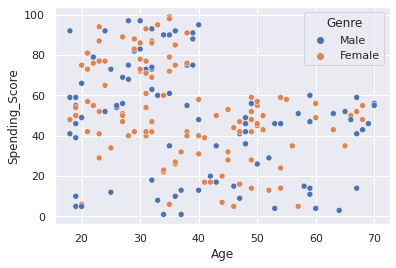

In [12]:
# basic visualizations

sns.scatterplot(x = 'Age', y = 'Spending_Score', hue = 'Genre', data = df)

<AxesSubplot:xlabel='Age', ylabel='Annual_Income'>

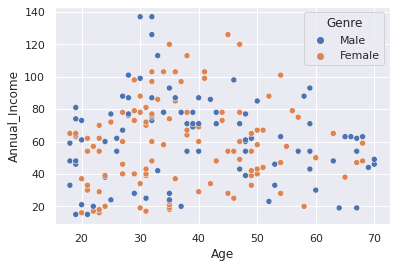

In [13]:
sns.scatterplot(x = 'Age', y = 'Annual_Income', hue = 'Genre', data = df)

<AxesSubplot:xlabel='Female', ylabel='Age'>

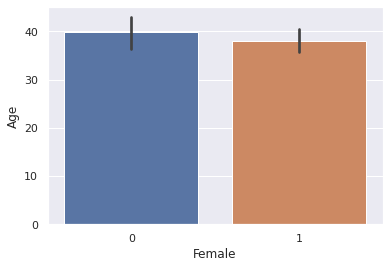

In [14]:
sns.barplot(y = 'Age', x = 'Female', data = df)

<AxesSubplot:xlabel='Age', ylabel='Count'>

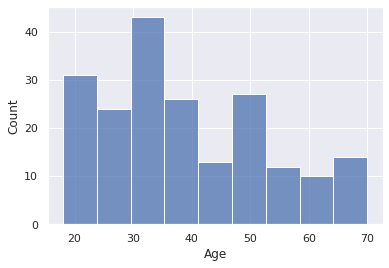

In [15]:
sns.histplot(df['Age'])

<AxesSubplot:xlabel='Genre', ylabel='Count'>

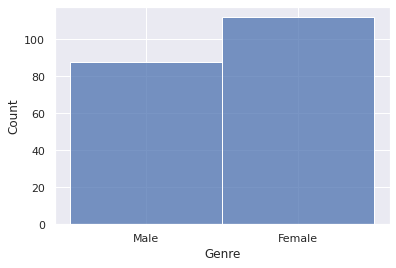

In [16]:
sns.histplot(df['Genre'])

In [17]:
print(sns.histplot.__doc__)

Plot univariate or bivariate histograms to show distributions of datasets.

A histogram is a classic visualization tool that represents the distribution
of one or more variables by counting the number of observations that fall within
disrete bins.

This function can normalize the statistic computed within each bin to estimate
frequency, density or probability mass, and it can add a smooth curve obtained
using a kernel density estimate, similar to :func:`kdeplot`.

More information is provided in the :ref:`user guide <tutorial_hist>`.

Parameters
----------
data : :class:`pandas.DataFrame`, :class:`numpy.ndarray`, mapping, or sequence
    Input data structure. Either a long-form collection of vectors that can be
    assigned to named variables or a wide-form dataset that will be internally
    reshaped.
x, y : vectors or keys in ``data``
    Variables that specify positions on the x and y axes.
hue : vector or key in ``data``
    Semantic variable that is mapped to determine the color o

<AxesSubplot:xlabel='Spending_Score', ylabel='Density'>

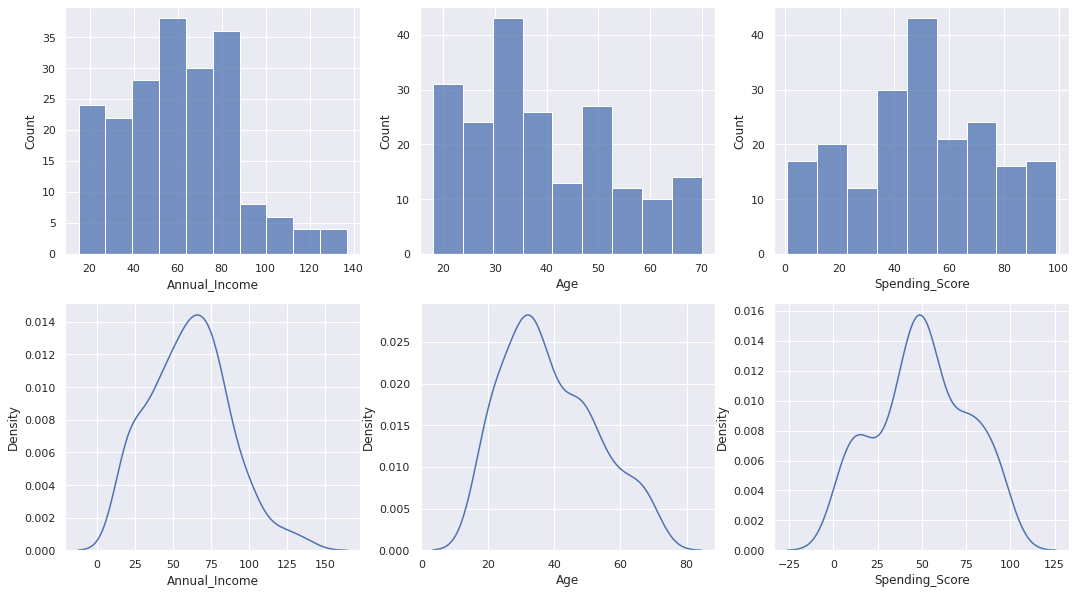

In [18]:
fig, axs = plt.subplots(2, 3, figsize = (18, 10))

sns.histplot(ax = axs[0,0], data = df['Annual_Income'])
sns.histplot(ax = axs[0,1], data = df['Age'])
sns.histplot(ax = axs[0,2], data = df['Spending_Score'])
sns.kdeplot(ax = axs[1,0], data = df['Annual_Income'])
sns.kdeplot(ax = axs[1,1], data = df['Age'])
sns.kdeplot(ax = axs[1,2], data = df['Spending_Score'])

<AxesSubplot:ylabel='Density'>

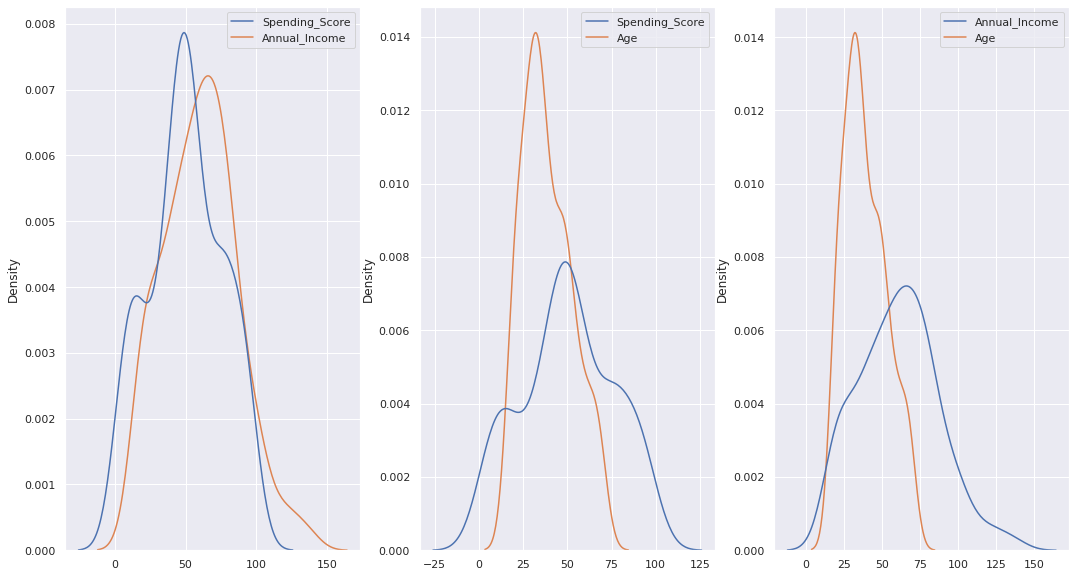

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (18, 10))

sns.kdeplot(ax = axs[0], data = df[['Spending_Score', 'Annual_Income']])
sns.kdeplot(ax = axs[1], data = df[['Spending_Score', 'Age']])
sns.kdeplot(ax = axs[2], data = df[['Annual_Income', 'Age']])

<AxesSubplot:ylabel='Age'>

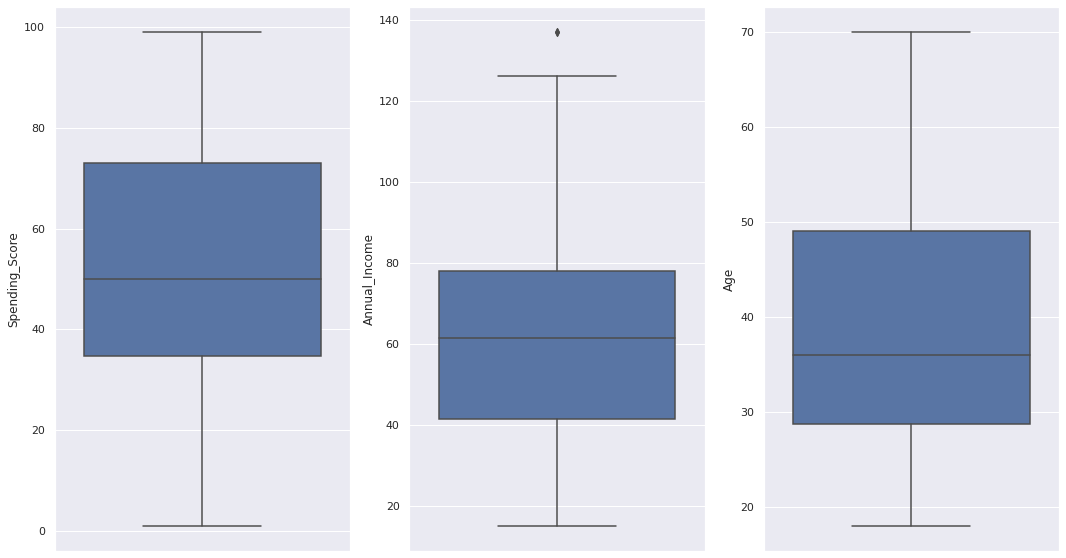

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (18, 10))

sns.boxplot(ax = axs[0], y = df['Spending_Score'])
sns.boxplot(ax = axs[1], y = df['Annual_Income'])
sns.boxplot(ax = axs[2], y = df['Age'])

In [21]:
df['Annual_Income'].idxmax()

199

In [22]:
# outlier in annual income

print(df['Annual_Income'].max())

print('\n')

print('quantiles:', np.quantile(df['Annual_Income'], [0.01, 0.99, 0.5, 0.95]))

print('\n')

print(df.iloc[df['Annual_Income'].idxmax() - 1])

137


quantiles: [ 15.99 126.11  61.5  103.  ]


Female               0
Male                 1
Genre             Male
Age                 32
Annual_Income      137
Spending_Score      18
Name: 199, dtype: object


<AxesSubplot:>

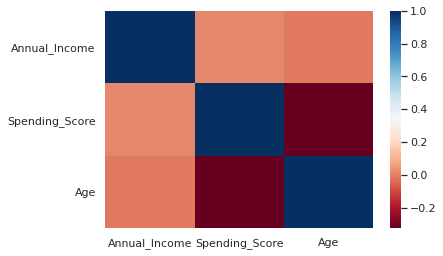

In [24]:
colunas = ['Annual_Income', 'Spending_Score', 'Age']

sns.heatmap(df[colunas].corr(), cmap = 'RdBu')

<AxesSubplot:xlabel='Annual_Income', ylabel='Spending_Score'>

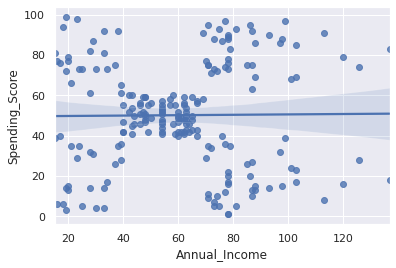

In [25]:
sns.regplot(x = 'Annual_Income', y = 'Spending_Score', data = df)

Pipeline:

```python
INPUT = [
    ('z-score': z_score()),
    ('cluster': kmeans()),
    ('labels': vq())
]

```

In [26]:
functions = [divide_by_max, min_max, z_score]

for func in functions:
    func(colunas)